In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.sparse import coo_matrix, csr_matrix

import implicit
from implicit.nearest_neighbours import bm25_weight
from sklearn.neighbors import NearestNeighbors
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
article_df = pd.read_csv('articles.csv')
article_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [3]:
article_df['article_id'].nunique(), article_df.shape[0]

(105542, 105542)

In [4]:
article_df['prod_name'].nunique()

45875

In [5]:
customer_df = pd.read_csv('customers 2.csv')
customer_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [6]:
transactions = pd.read_csv('transactions_train.csv')

In [7]:
print(transactions.shape)

(31788324, 5)


In [8]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [9]:
transactions.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [10]:
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
transactions['t_dat'].min(), transactions['t_dat'].max()

(Timestamp('2018-09-20 00:00:00'), Timestamp('2020-09-22 00:00:00'))

In [11]:
hm = transactions.merge(customer_df, on="customer_id", how="left")

In [12]:
hm = hm.merge(article_df, on="article_id", how="left")

In [13]:
hm.head()

,t_dat,customer_id,article_id,price,sales_channel_id,FN,Active,club_member_status,fashion_news_frequency,age,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,NaN,NaN,ACTIVE,NONE,24.0,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,NaN,NaN,ACTIVE,NONE,24.0,...,Casual Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up bras with underwired, moulded, pa..."
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,1.0,1.0,ACTIVE,Regularly,32.0,...,Tops Knitwear DS,D,Divided,2,Divided,58,Divided Selected,1003,Knitwear,Jumper in rib-knit cotton with hard-worn detai...
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,1.0,1.0,ACTIVE,Regularly,32.0,...,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,V-neck knitted jumper with long sleeves and ri...
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,1.0,1.0,ACTIVE,Regularly,32.0,...,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,V-neck knitted jumper with long sleeves and ri...


In [14]:
hm.shape

(31788324, 35)

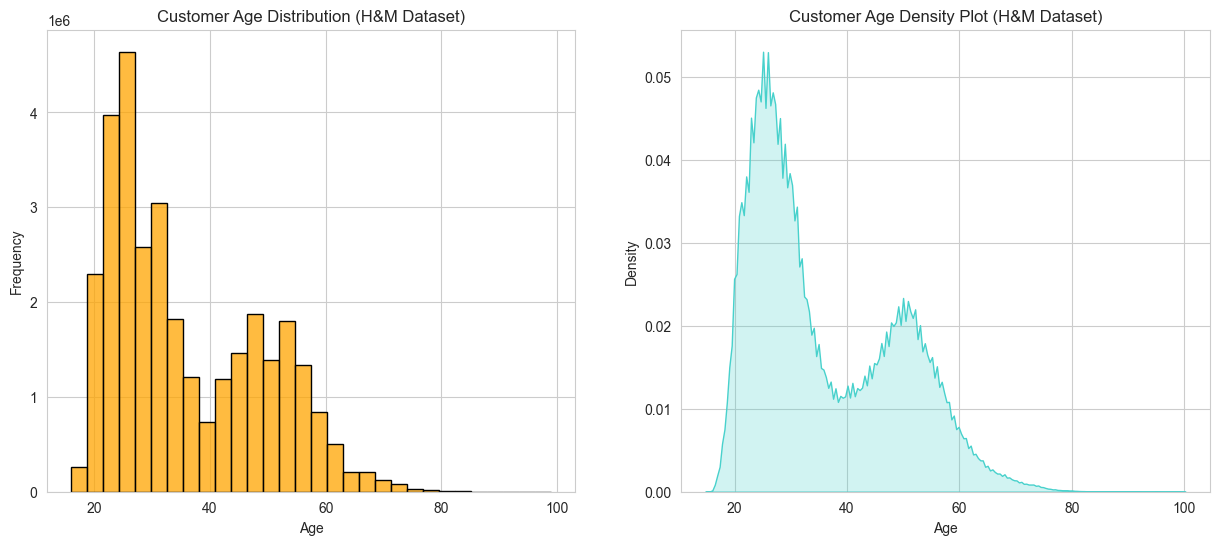

In [17]:
plt.figure(figsize=(15, 6))
sns.set_style("whitegrid")

plt.subplot(1, 2, 1)
sns.histplot(hm['age'], bins=30, color='orange', edgecolor='black')
plt.title('Customer Age Distribution (H&M Dataset)')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.kdeplot(hm['age'], color='mediumturquoise', shade=True)
plt.title('Customer Age Density Plot (H&M Dataset)')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

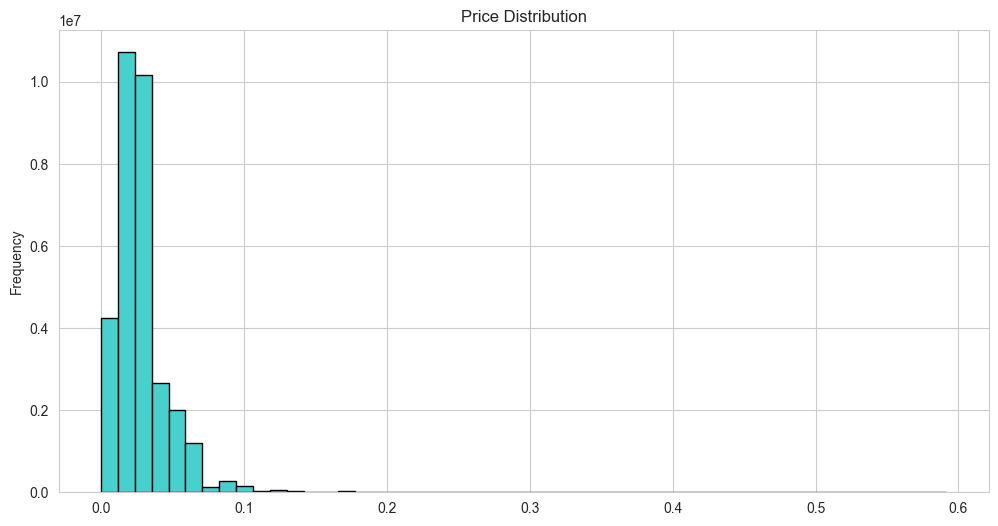

In [18]:
hm['price'].plot(kind='hist', bins=50, figsize=(12,6),color = 'mediumturquoise', edgecolor='black')
plt.title("Price Distribution")
plt.show()

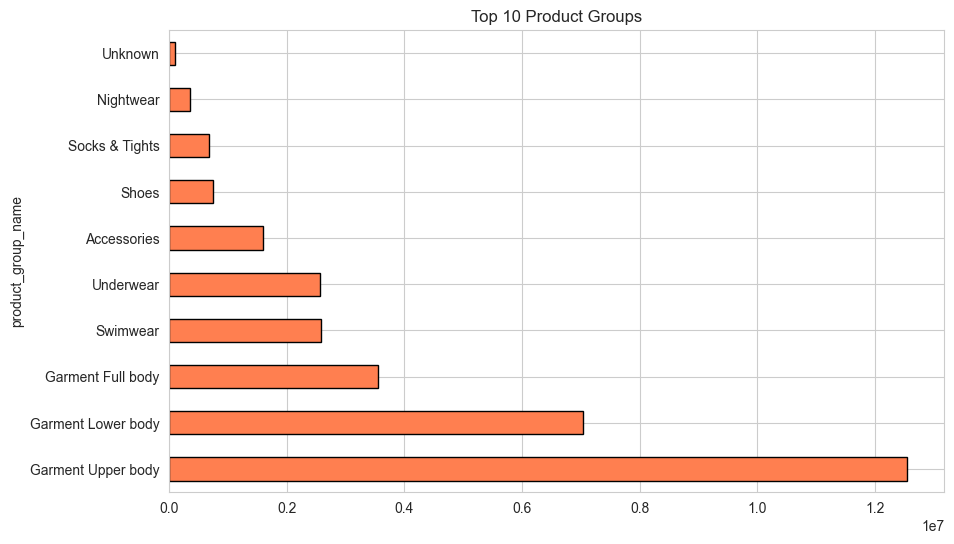

In [19]:
hm['product_group_name'].value_counts().head(10).plot(kind='barh', figsize=(10,6), color='coral', edgecolor='black')
plt.title("Top 10 Product Groups")
plt.show()

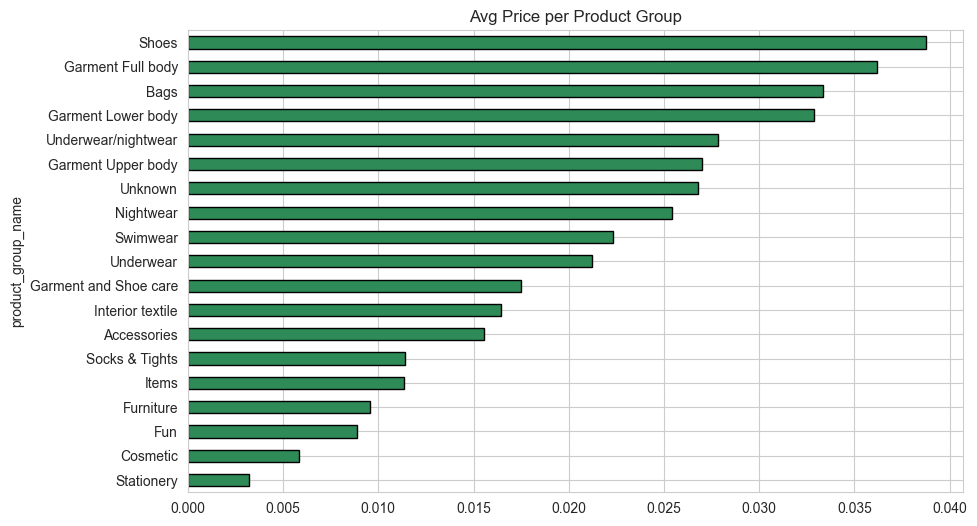

In [20]:
hm.groupby('product_group_name')['price'].mean().sort_values().plot(kind='barh', figsize=(10,6), color='seagreen', edgecolor='black')
plt.title("Avg Price per Product Group")
plt.show()

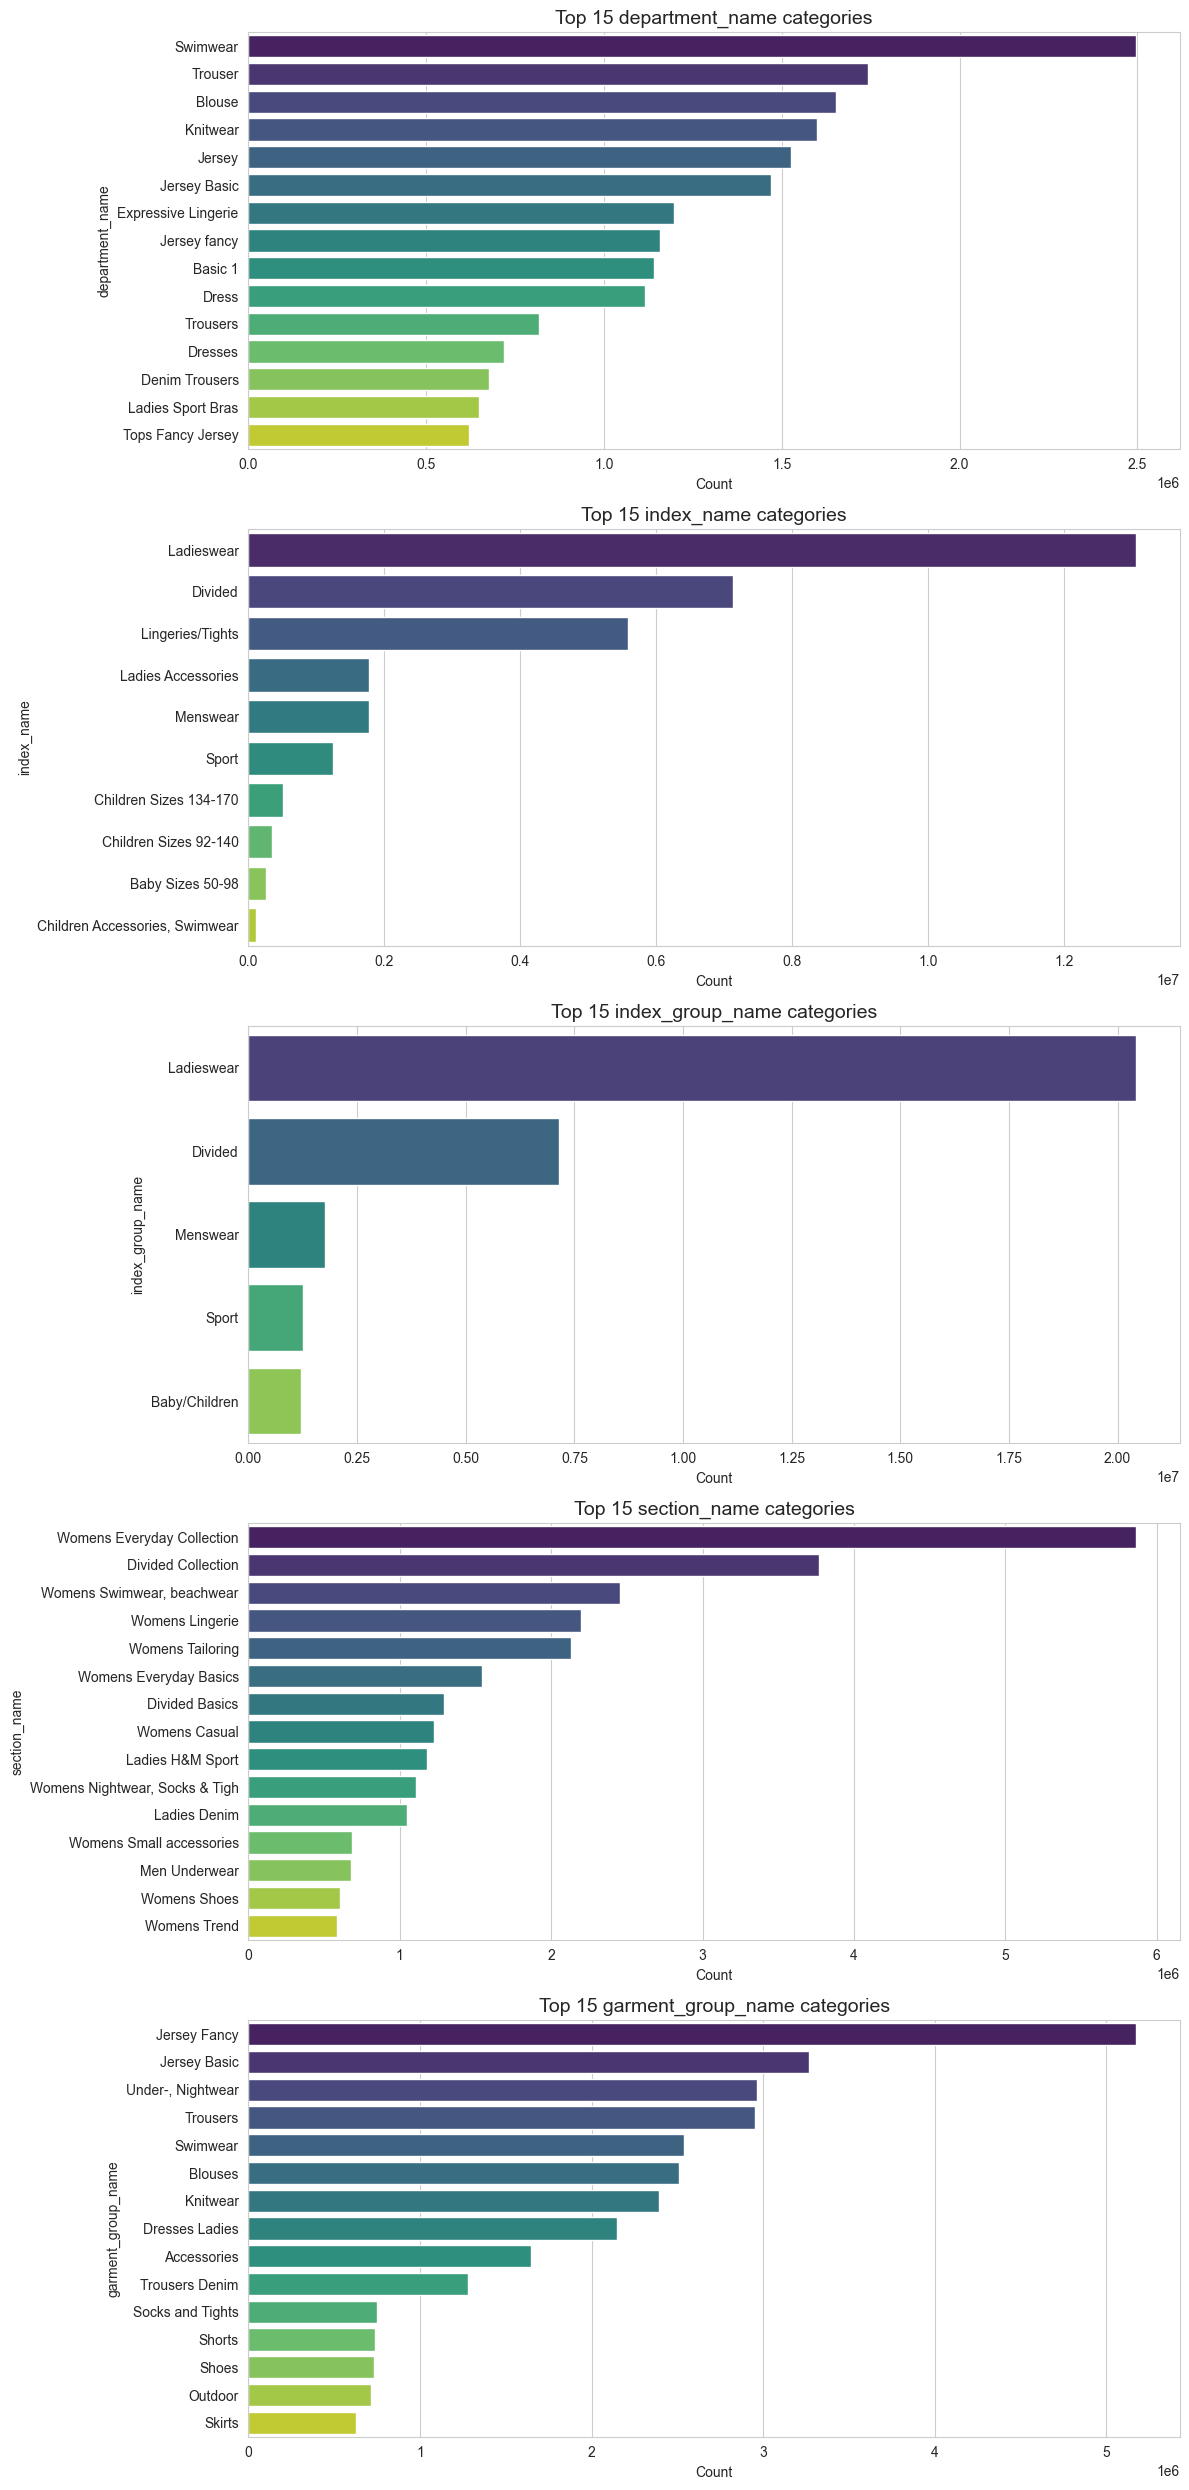

In [21]:
# List of categorical features to explore
features = ["department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]

# Plot top categories for each feature
fig, axes = plt.subplots(len(features), 1, figsize=(12, 25))

for i, col in enumerate(features):
    top_counts = hm[col].value_counts().head(15)   # top 15 categories
    sns.barplot(x=top_counts.values, y=top_counts.index, ax=axes[i], palette="viridis")
    axes[i].set_title(f"Top 15 {col} categories", fontsize=14)
    axes[i].set_xlabel("Count")
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()

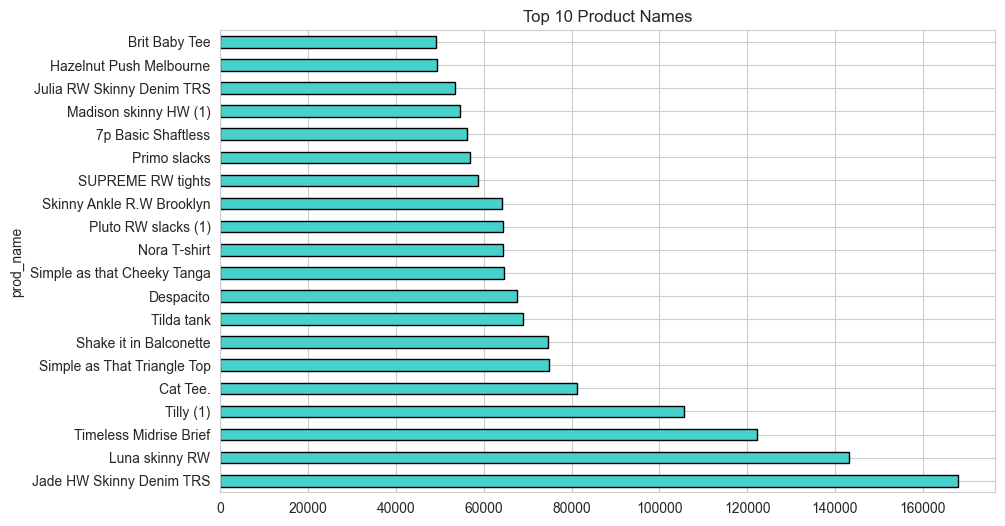

In [22]:
hm['prod_name'].value_counts().head(20).plot(kind='barh', figsize=(10,6), color= 'mediumturquoise', edgecolor='black')
plt.title("Top 10 Product Names")
plt.show()

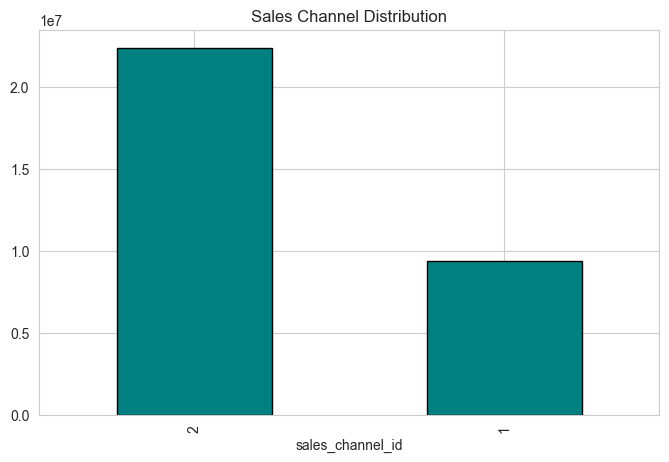

In [23]:
# Sales channel split
hm['sales_channel_id'].value_counts().plot(kind='bar', figsize=(8,5), color='teal', edgecolor='black')
plt.title("Sales Channel Distribution")
plt.show()

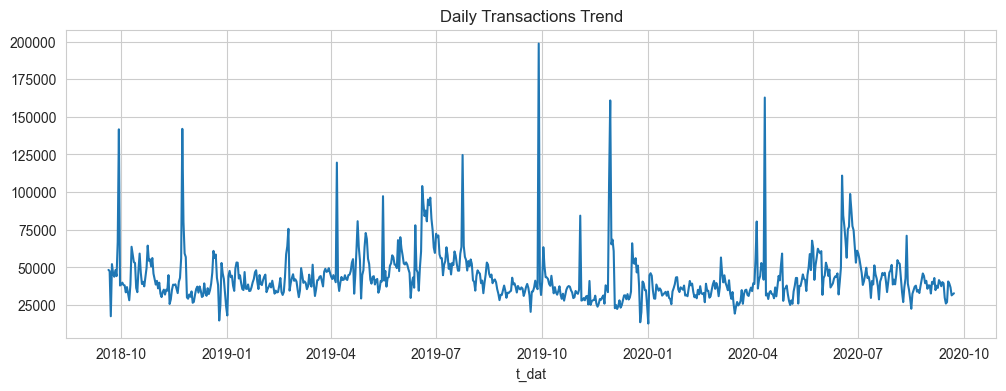

In [24]:
hm.groupby(hm['t_dat'].dt.date).size().plot(figsize=(12,4))
plt.title("Daily Transactions Trend")
plt.show()

In [25]:
hm['month'] = hm['t_dat'].dt.to_period('M').dt.to_timestamp()

In [26]:
monthly_dept = hm.groupby(['month','department_name']).size().reset_index(name='count')
top_depts = monthly_dept.groupby('department_name')['count'].sum().nlargest(5).index

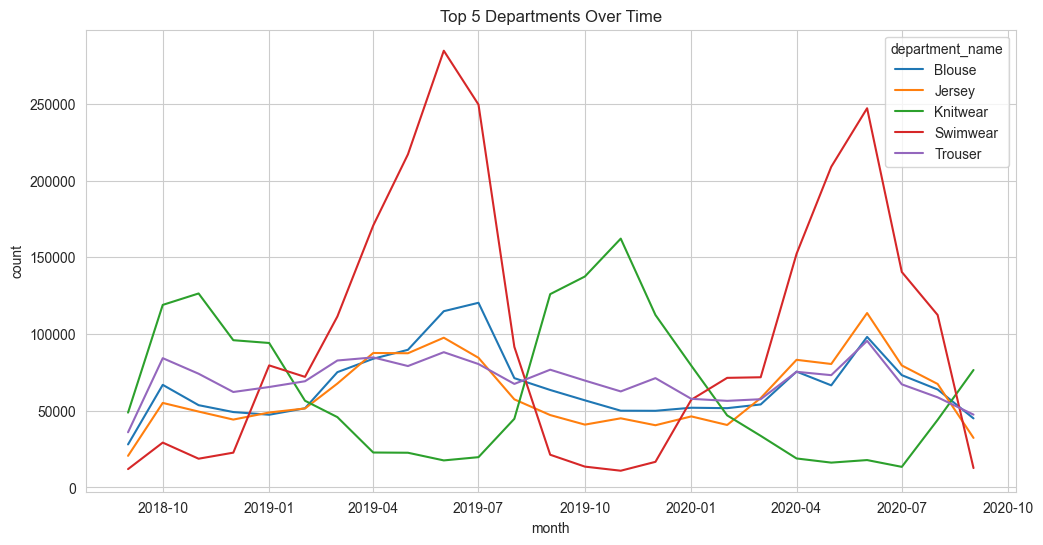

In [27]:
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_dept[monthly_dept['department_name'].isin(top_depts)], 
             x='month', y='count', hue='department_name')
plt.title("Top 5 Departments Over Time")
plt.show()

In [28]:
hm['age_group'] = pd.cut(hm['age'], bins=[0,20,30,40,50,60,100], 
                         labels=['<20','20s','30s','40s','50s','60+'])

In [29]:
age_section = hm.groupby(['age_group','section_name']).size().reset_index(name='count')
top_sections = age_section.groupby('section_name')['count'].sum().nlargest(5).index

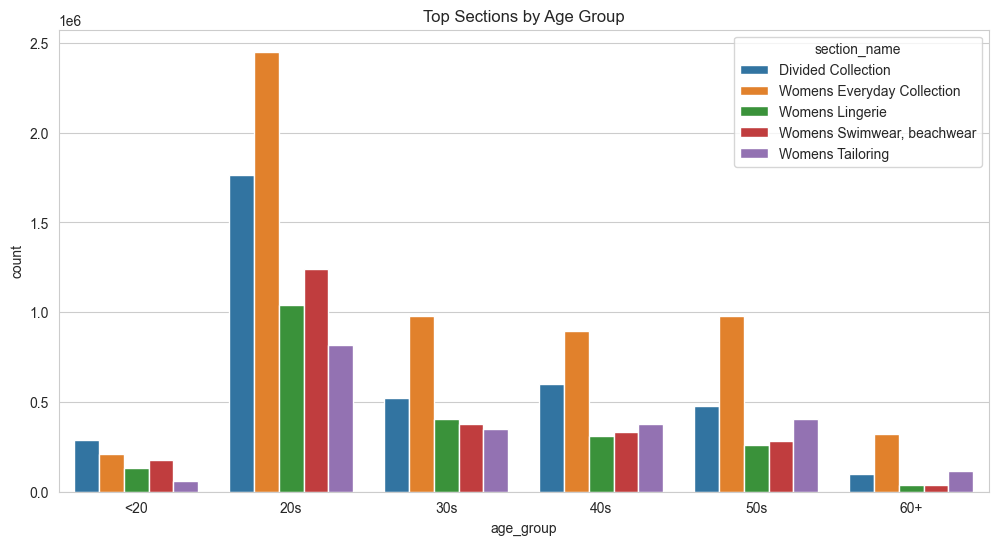

In [30]:
plt.figure(figsize=(12,6))
sns.barplot(data=age_section[age_section['section_name'].isin(top_sections)],
            x='age_group', y='count', hue='section_name')
plt.title("Top Sections by Age Group")
plt.show()

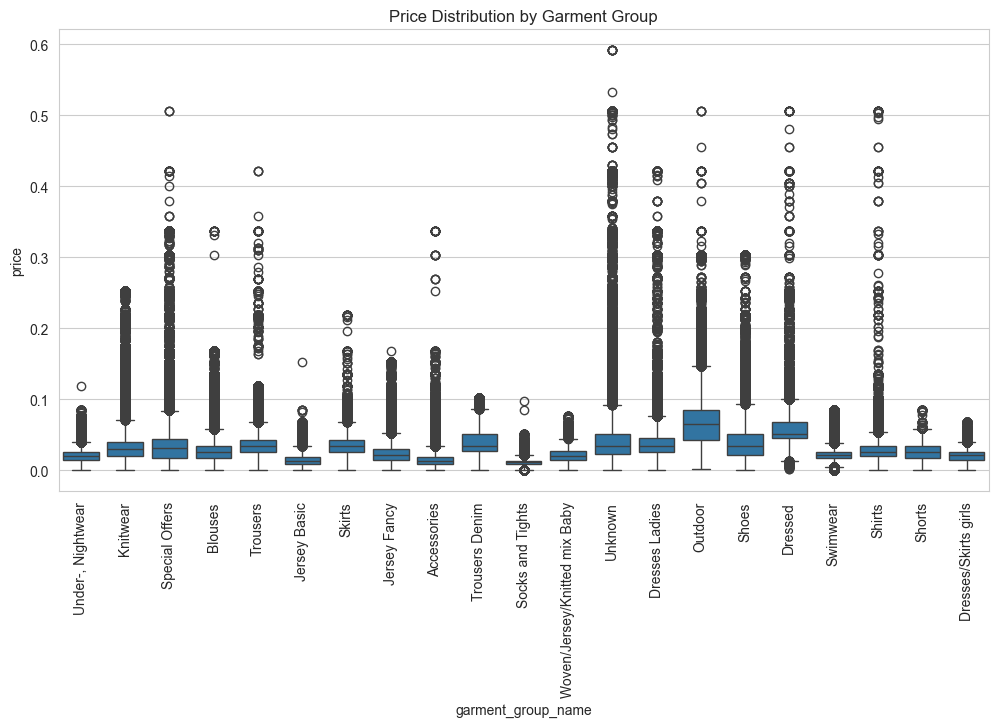

In [31]:
plt.figure(figsize=(12,6))
sns.boxplot(data=hm, x='garment_group_name', y='price')
plt.xticks(rotation=90)
plt.title("Price Distribution by Garment Group")
plt.show()

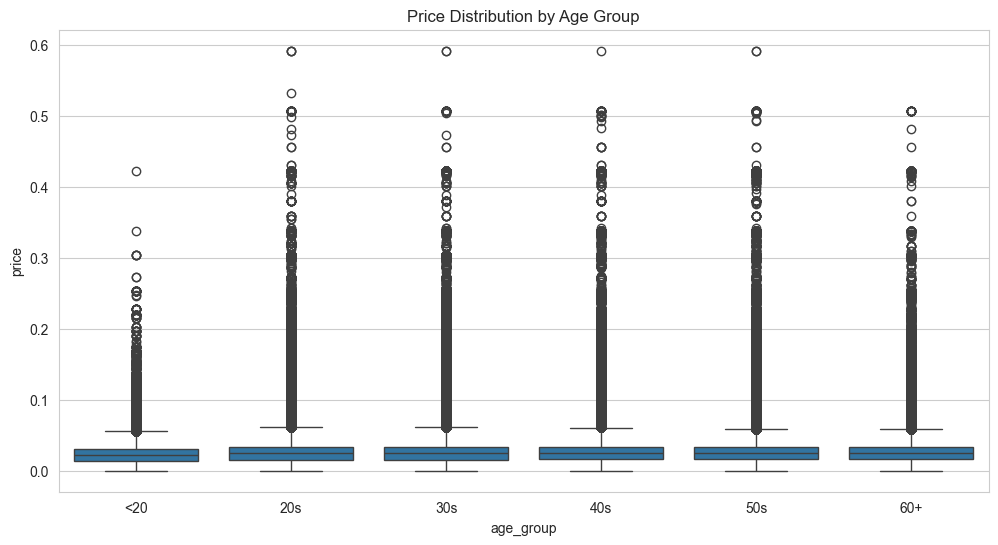

In [32]:
plt.figure(figsize=(12,6))
sns.boxplot(data=hm, x='age_group', y='price')
plt.title("Price Distribution by Age Group")
plt.show()

In [33]:
hm['weekday'] = hm['t_dat'].dt.day_name()

# Count transactions per weekday
weekday_counts = hm['weekday'].value_counts().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

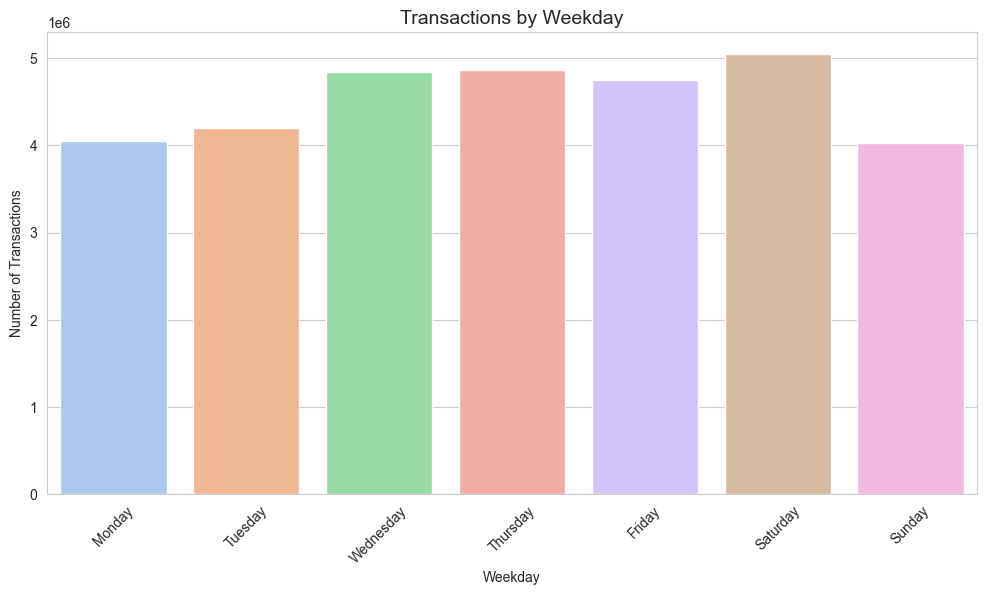

In [34]:
# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette="pastel")
plt.title("Transactions by Weekday", fontsize=14)
plt.ylabel("Number of Transactions")
plt.xlabel("Weekday")
plt.xticks(rotation=45)
plt.show()

In [35]:
cf_hm = hm[['customer_id', 'article_id']].copy()

In [36]:
cf_hm = cf_hm.groupby(['customer_id','article_id']).size().reset_index(name='purchases')

In [37]:
cf_hm.head()

,customer_id,article_id,purchases
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,176209023,1
1,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601006,2
2,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601043,1
3,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,607642008,1
4,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,625548001,1


Text(0.5, 0, 'Number of Purchases')

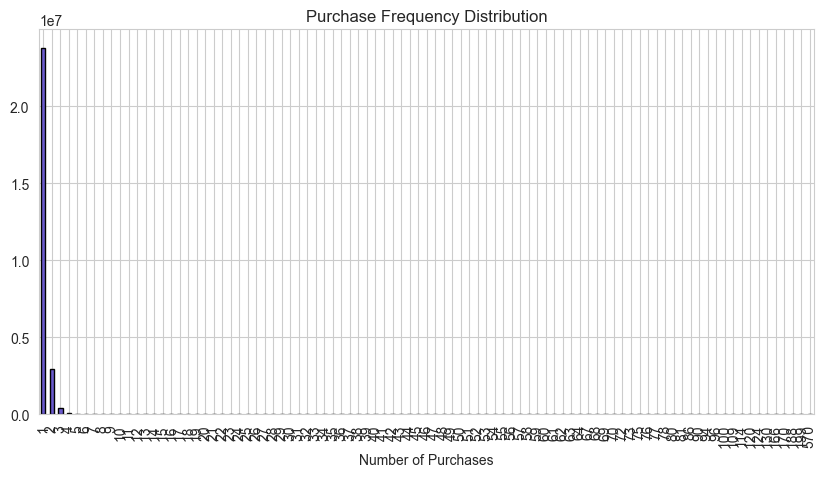

In [38]:
cf_hm['purchases'].value_counts().sort_index().plot(kind='bar', figsize=(10,5), color='slateblue', edgecolor='black')
plt.title("Purchase Frequency Distribution")
plt.xlabel("Number of Purchases")

In [39]:
popular_items = hm['prod_name'].value_counts().head(50)

In [40]:
popular_items.head()

prod_name
Jade HW Skinny Denim TRS    168052
Luna skinny RW              143216
Timeless Midrise Brief      122143
Tilly (1)                   105670
Cat Tee.                     81304
Name: count, dtype: int64

In [41]:
recent_popular = hm[hm['t_dat'] >= "2020-08-01"]['prod_name'].value_counts().head(50)
recent_popular.head()

prod_name
Pluto RW slacks (1)         13559
Jade HW Skinny Denim TRS    13153
Tilly (1)                    9965
Lucy blouse                  9097
Cat Tee.                     8801
Name: count, dtype: int64

In [44]:
# Encode IDs
user_enc = LabelEncoder()
item_enc = LabelEncoder()

cf_hm['user_id'] = user_enc.fit_transform(cf_hm['customer_id'])
cf_hm['item_id'] = item_enc.fit_transform(cf_hm['article_id'])

In [46]:
# Sparse matrix
user_item_matrix = csr_matrix(
    (cf_hm['purchases'], (cf_hm['user_id'], cf_hm['item_id']))
)

In [47]:
print("Matrix shape:", user_item_matrix.shape)   # (n_users, n_prod_names)
print("Non-zero entries:", user_item_matrix.nnz)

Matrix shape: (1362281, 104547)
Non-zero entries: 27306439


In [48]:
# Compute similarity for a small subset (e.g. top 500 items for speed)
subset = user_item_matrix[:, :500] 

In [50]:
item_sim = cosine_similarity(subset.T)

In [51]:
print("Item similarity matrix shape:", item_sim.shape)

Item similarity matrix shape: (500, 500)


In [52]:
# Pick a product to test (e.g. first one in encoder)
test_item = 112
similar_items = item_sim[test_item].argsort()[::-1][1:6]  # top 5 excluding itself

print("Product:", item_enc.inverse_transform([test_item])[0])
print("Similar products:", item_enc.inverse_transform(similar_items))

Product: 176754001
Similar products: [176754003 176754019 220094016 212042043 216961011]


In [53]:
article_df.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [54]:
article_df.isna().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

In [55]:
article_df.shape

(105542, 25)

In [56]:
item_features = [
    'article_id', 
    'prod_name', 
    'product_type_name', 
    'product_group_name', 
    'graphical_appearance_name', 
    'colour_group_name', 
    'department_name', 
    'index_name', 
    'index_group_name', 
    'section_name', 
    'garment_group_name', 
    'detail_desc'
]

In [57]:
items_df = article_df[item_features].copy()
items_df.head()

,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc
0,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,Strap top,Vest top,Garment Upper body,Solid,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,OP T-shirt (Idro),Bra,Underwear,Solid,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [58]:
# Fill missing detail_desc

items_df['detail_desc'] = items_df['detail_desc'].fillna("")

In [59]:
items_df['index_group_name'].unique()

array(['Ladieswear', 'Baby/Children', 'Menswear', 'Sport', 'Divided'],
      dtype=object)

In [60]:
items_df['metadata'] = (
    items_df['product_type_name'] + ' ' +
    items_df['product_group_name'] + ' ' +
    items_df['graphical_appearance_name'] + ' ' +
    items_df['colour_group_name'] + ' ' +
    items_df['index_group_name'] + ' ' +
    items_df['section_name'] + ' ' +
    items_df['garment_group_name'] + ' ' +
    items_df['detail_desc']
)

In [61]:
items_df.head()

,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,metadata
0,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,Vest top Garment Upper body Solid Black Ladies...
1,108775044,Strap top,Vest top,Garment Upper body,Solid,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,Vest top Garment Upper body Solid White Ladies...
2,108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.,Vest top Garment Upper body Stripe Off White L...
3,110065001,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",Bra Underwear Solid Black Ladieswear Womens Li...
4,110065002,OP T-shirt (Idro),Bra,Underwear,Solid,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",Bra Underwear Solid White Ladieswear Womens Li...


In [62]:
# Remove safely if present
for col in ['article_id', 'prod_name']:
    if col in item_features:
        item_features.remove(col)

# Now drop the remaining features
items_df.drop(columns=item_features, inplace=True)

items_df.head()

,article_id,prod_name,metadata
0,108775015,Strap top,Vest top Garment Upper body Solid Black Ladies...
1,108775044,Strap top,Vest top Garment Upper body Solid White Ladies...
2,108775051,Strap top (1),Vest top Garment Upper body Stripe Off White L...
3,110065001,OP T-shirt (Idro),Bra Underwear Solid Black Ladieswear Womens Li...
4,110065002,OP T-shirt (Idro),Bra Underwear Solid White Ladieswear Womens Li...


In [63]:
items_df['metadata'][0]

'Vest top Garment Upper body Solid Black Ladieswear Womens Everyday Basics Jersey Basic Jersey top with narrow shoulder straps.'

In [64]:
# Create TF-IDF vectors from metadata
tfidf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf.fit_transform(items_df['metadata'])

print(tfidf_matrix.shape)  # (num_items, num_features)

(105542, 3850)


In [65]:
# Step 2: Map article_id to row index
id_to_index = pd.Series(items_df.index, index=items_df['article_id'])

In [66]:
id_to_index

article_id
108775015         0
108775044         1
108775051         2
110065001         3
110065002         4
              ...  
953450001    105537
953763001    105538
956217002    105539
957375001    105540
959461001    105541
Length: 105542, dtype: int64

In [67]:
# Step 3: Function to get top-N similar items
def get_similar_items(article_id, top_n=10):
    if article_id not in id_to_index:
        print("Article ID not found in items_df")
        return None
    
    idx = id_to_index[article_id]
    
    # Compute cosine similarity with all items
    cosine_sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
    
    # Get top-N most similar items (excluding itself)
    sim_indices = cosine_sim.argsort()[-top_n-1:][::-1]
    sim_indices = sim_indices[sim_indices != idx]
    
    # Fetch product names instead of metadata
    results = items_df.iloc[sim_indices][['article_id', 'prod_name']].copy()
    results['similarity'] = cosine_sim[sim_indices]
    
    # Get chosen item name
    chosen_item = items_df.loc[items_df['article_id'] == article_id, 'prod_name'].values[0]
    print(f"Chosen item ({article_id}): {chosen_item}\n")
    
    return results.head(top_n)

In [70]:
def get_image_path(article_id, base_dir="images_128_128"):
    article_id = str(article_id).zfill(10)   # make sure it's always 10 digits
    folder = article_id[:3]                 # first 3 digits for subfolder
    return os.path.join(base_dir, folder, article_id + ".jpg")

# Example
print(get_image_path(850064001))

images_128_128/085/0850064001.jpg


In [71]:
def show_recommendations_with_images(chosen_id, recommendations, base_dir="images_128_128"):
    
    # Create figure: 1 row, N+1 columns (chosen + recommendations)
    fig, axes = plt.subplots(1, len(recommendations) + 1, figsize=(15, 5))
    
    # --- Show chosen item ---
    chosen_id_str = str(chosen_id).zfill(10)
    chosen_prod = items_df.loc[items_df['article_id'] == chosen_id, 'prod_name'].values[0]
    chosen_img_path = get_image_path(chosen_id_str, base_dir)
    
    if os.path.exists(chosen_img_path):
        img = mpimg.imread(chosen_img_path)
        axes[0].imshow(img)
    else:
        axes[0].text(0.5, 0.5, "No Image", ha='center', va='center')
    
    axes[0].set_title(f"Chosen:\n{chosen_prod[:15]}...", fontsize=9)
    axes[0].axis('off')
    
    # --- Show recommended items ---
    for ax, (_, row) in zip(axes[1:], recommendations.iterrows()):
        article_id = str(row['article_id']).zfill(10)
        img_path = get_image_path(article_id, base_dir)
        
        if os.path.exists(img_path):
            img = mpimg.imread(img_path)
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "No Image", ha='center', va='center')
        
        ax.set_title(row['prod_name'][:15] + "...", fontsize=9)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [72]:
# Example: get top-10 similar items for one article
similar_items = get_similar_items(868495005, top_n=10)
print(similar_items)

Chosen item (868495005): BYRON hood TP

       article_id         prod_name  similarity
95975   868495001     BYRON hood TP    1.000000
95979   868495027     BYRON hood TP    0.970190
84586   816355003  BYRON fancy hood    0.932287
84584   816355001  BYRON fancy hood    0.925268
84585   816355002  BYRON fancy hood    0.923984
95978   868495006     BYRON hood TP    0.907255
15014   565036003         Noah hood    0.864555
95976   868495004     BYRON hood TP    0.831449
83651   812840001         Mick hood    0.815505
15016   565036009         Noah hood    0.804141


In [73]:
cust_encoder = LabelEncoder()
transactions['customer_id_enc'] = cust_encoder.fit_transform(transactions['customer_id'])

In [74]:
# Store mapping for later lookup
id_to_customer = dict(enumerate(cust_encoder.classes_))
customer_to_id = {v: k for k, v in id_to_customer.items()}

print("Encoded shape:", transactions[['customer_id', 'customer_id_enc']].head())

Encoded shape:                                          customer_id  customer_id_enc
0  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...                2
1  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...                2
2  00007d2de826758b65a93dd24ce629ed66842531df6699...                7
3  00007d2de826758b65a93dd24ce629ed66842531df6699...                7
4  00007d2de826758b65a93dd24ce629ed66842531df6699...                7


In [75]:
def show_customer_recommendations(recommendations, base_dir="images_128_128"):
    """Display only recommended items with their images (no chosen item)."""
    if recommendations is None or recommendations.empty:
        print("No recommendations to display.")
        return

    fig, axes = plt.subplots(1, len(recommendations), figsize=(15, 5))
    if len(recommendations) == 1:
        axes = [axes]  # ensure iterable for single item

    for ax, (_, row) in zip(axes, recommendations.iterrows()):
        article_id = str(row['article_id']).zfill(10)
        img_path = get_image_path(article_id, base_dir)

        if os.path.exists(img_path):
            img = mpimg.imread(img_path)
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "No Image", ha='center', va='center')

        ax.set_title(f"{row['prod_name'][:15]}...", fontsize=9)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [76]:
def recommend_for_customer_enc_dynamic(customer_id_enc, transactions, top_n=10, base_dir="images_128_128"):
    """
    Recommend products to a customer based on their purchase history using adaptive weighting.
    - New users (<=3 purchases): average similarity of last few items.
    - Regular users (4–10 purchases): recency-weighted similarity.
    - Heavy users (>10 purchases): exponential decay weighting.
    """

    user_txn = transactions[transactions['customer_id_enc'] == customer_id_enc]
    if user_txn.empty:
        print("No transactions found for this customer.")
        return None

    bought_items = user_txn['article_id'].unique()
    n_items = len(bought_items)

    scores = np.zeros(tfidf_matrix.shape[0])

    # 1️⃣ Case 1: New users (1–3 purchases)
    if n_items <= 3:
        print(f"🆕 New customer (only {n_items} purchases) → averaging similarities")
        for item in bought_items:
            if item in id_to_index:
                idx = id_to_index[item]
                scores += cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
        scores /= n_items  # simple average

    # 2️⃣ Case 2: Regular users (4–10 purchases)
    elif n_items <= 10:
        print(f"👟 Regular customer ({n_items} purchases) → recency-weighted similarity")
        weights = np.linspace(0.5, 1.0, n_items)  # recent items get higher weight
        weights /= weights.sum()

        for w, item in zip(weights[::-1], bought_items[::-1]):  # reverse = most recent last
            if item in id_to_index:
                idx = id_to_index[item]
                scores += w * cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()

    # 3️⃣ Case 3: Heavy users (>10 purchases)
    else:
        print(f"🏆 Heavy customer ({n_items} purchases) → exponential decay weighting")
        decay = np.exp(-np.arange(n_items)[::-1] / 5)  # decay factor, tweak denominator
        decay /= decay.sum()

        for w, item in zip(decay, bought_items[::-1]):
            if item in id_to_index:
                idx = id_to_index[item]
                scores += w * cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()

    # Remove already purchased items
    bought_indices = [id_to_index[i] for i in bought_items if i in id_to_index]
    scores[bought_indices] = 0

    # Get top-N recommendations
    sim_indices = scores.argsort()[-top_n:][::-1]
    results = items_df.iloc[sim_indices][['article_id', 'prod_name']].copy()
    results['similarity'] = scores[sim_indices]

    # Display results
    print(f"\n🛍️ Recommendations for customer_id_enc = {customer_id_enc}")
    show_customer_recommendations(results, base_dir=base_dir)

    return results

🏆 Heavy customer (43 purchases) → exponential decay weighting

🛍️ Recommendations for customer_id_enc = 87645


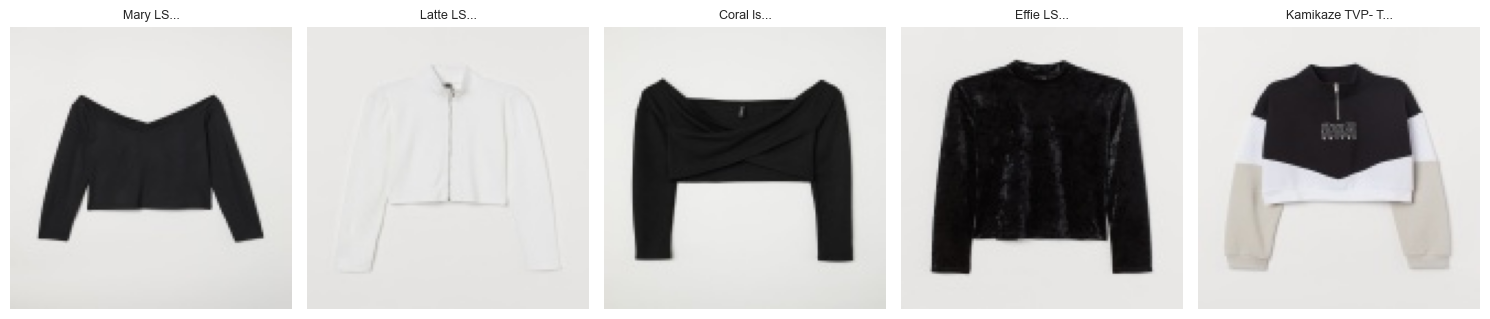

,article_id,prod_name,similarity
13584,558986001,Mary LS,0.380760
87406,827680001,Latte LS,0.379079
34382,641666001,Coral ls,0.376888
102939,907951001,Effie LS,0.376885
68584,754713003,Kamikaze TVP- TM,0.374028


In [77]:
recommend_for_customer_enc_dynamic(87645, transactions, top_n=5)

Chosen item (727880001): Mimmi new



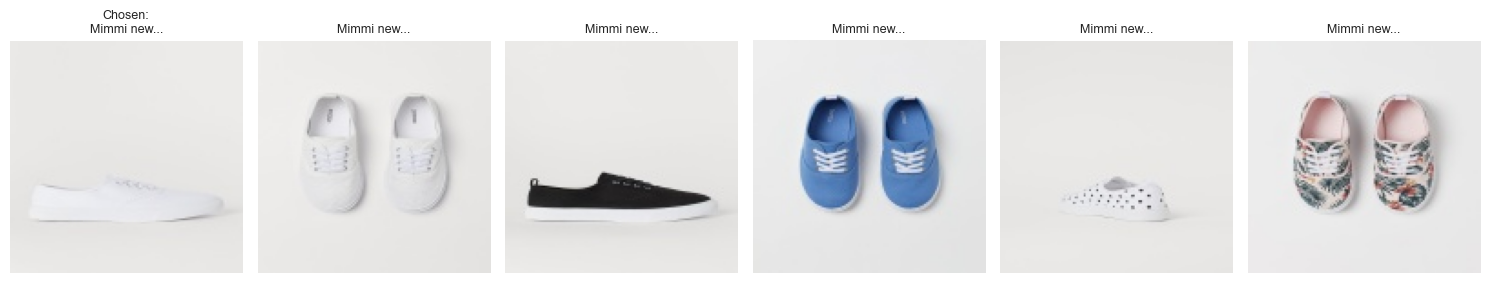

In [78]:
chosen_id = 727880001
recs = get_similar_items(chosen_id, top_n=5)
show_recommendations_with_images(chosen_id, recs, base_dir="images_128_128")

In [79]:
article_df[article_df['prod_name'] == 'Jade HW Skinny Denim TRS'].head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
53892,706016001,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,9,Black,...,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...
53893,706016002,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,71,Light Blue,...,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...
53894,706016003,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,73,Dark Blue,...,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...
53895,706016004,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010014,Placement print,71,Light Blue,...,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...
53896,706016006,706016,Jade HW Skinny Denim TRS,272,Trousers,Garment Lower body,1010016,Solid,73,Dark Blue,...,Trousers,D,Divided,2,Divided,53,Divided Collection,1009,Trousers,High-waisted jeans in washed superstretch deni...


In [80]:
# 1) Count interactions (you can also weight by price/recency later)
# Use transaction count as implicit feedback strength
ui = (transactions.
      groupby(['customer_id_enc', 'article_id']).size().reset_index(name='count') )

In [81]:
ui.head()

,customer_id_enc,article_id,count
0,0,176209023,1
1,0,568601006,2
2,0,568601043,1
3,0,607642008,1
4,0,625548001,1


In [82]:
# Interaction signal using log smoothing
ui['weight'] = np.log1p(ui['count']).astype('float32')

In [83]:
unique_users = ui['customer_id_enc'].unique()
unique_items = ui['article_id'].unique()

In [84]:
# Create integer index for users/items for matrix factorization
user_to_idx = {u: i for i, u in enumerate(unique_users)}
item_to_idx = {i: j for j, i in enumerate(unique_items)}


# Reverse lookup
idx_to_user = pd.Series(unique_users)
idx_to_item = pd.Series(unique_items)

In [85]:
rows = ui['customer_id_enc'].map(user_to_idx)
cols = ui['article_id'].map(item_to_idx)
data = ui['weight'].astype(float)

In [86]:
user_item = csr_matrix((data, (rows, cols)), shape=(len(user_to_idx), len(item_to_idx)))
item_user = user_item.T.tocsr()  # ALS wants item-user

In [89]:
item_user_bm25 = bm25_weight(item_user, K1=1.2, B=0.75).tocsr()

In [90]:
X = item_user_bm25

In [91]:
als_model = implicit.als.AlternatingLeastSquares(
    factors=64,
    regularization=0.01,
    iterations=20,
    random_state=42
)

In [92]:
als_model.fit(X)

100%|██████████| 20/20 [05:11<00:00, 15.60s/it]


In [93]:
def recommend_for_customer_als_strong(customer_id_enc, top_n=10, extra_factor=20, base_dir="images_128_128"):
    """
    ALS-based recommendation with aggressive recall + image display.
    """
    if customer_id_enc not in user_to_idx:
        print("Customer not found in ALS model.")
        return None

    uidx = user_to_idx[customer_id_enc]
    user_vector = user_item[uidx]

    # Ask ALS for more candidates to improve recall
    N = max(top_n * extra_factor, top_n + 200)

    item_indices, scores = als_model.recommend(
        userid=uidx,
        user_items=user_vector,
        N=N,
        filter_already_liked_items=True,
        recalculate_user=True
    )

    # Filter safe indices
    valid_pairs = [(i, s) for i, s in zip(item_indices, scores) if 0 <= i < len(idx_to_item)]
    if not valid_pairs:
        print("No ALS recommendations found.")
        return None

    # Keep only top_n
    valid_pairs = valid_pairs[:top_n]
    items, scrs = zip(*valid_pairs)
    rec_article_ids = pd.Series(idx_to_item).iloc[list(items)].astype(int).values

    # Create results dataframe
    df = pd.DataFrame({
        'article_id': rec_article_ids,
        'score': scrs
    }).merge(items_df[['article_id', 'prod_name']], on='article_id', how='left')

    print(f"\n📊 ALS Recommendations for customer_id_enc = {customer_id_enc}")
    show_customer_recommendations(df[['article_id', 'prod_name']], base_dir=base_dir)

    return df[['article_id', 'prod_name', 'score']]


📊 ALS Recommendations for customer_id_enc = 3910


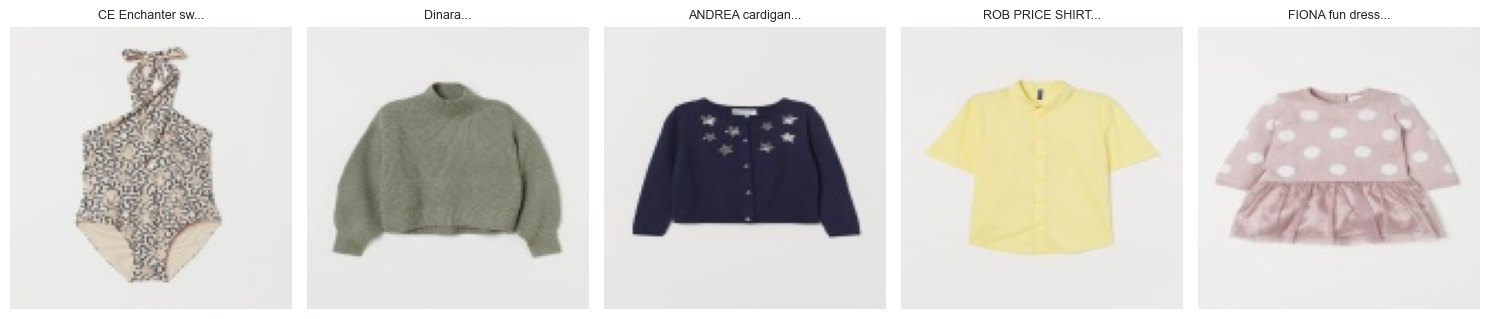

,article_id,prod_name,score
0,737637001,CE Enchanter swimsuit,0.000065
1,825688002,Dinara,0.000056
2,768553006,ANDREA cardigan speed,0.000054
3,838780006,ROB PRICE SHIRT,0.000046
4,657871003,FIONA fun dress,0.000046


In [94]:
recommend_for_customer_als_strong(3910, top_n=5)

In [95]:
def compare_cb_vs_als(customer_id_enc, transactions, top_n=5, base_dir="images_128_128"):
    """
    Compare Content-Based and ALS recommendations for a given customer.
    - Displays top 10 most frequently purchased items (2 rows)
    - Shows Content-Based and ALS recommendations separately
    - No hybrid mixing, clean minimal output
    """

    # =========================
    # 1️⃣ Customer’s Top 10 Purchased Items
    # =========================
    user_txn = transactions[transactions['customer_id_enc'] == customer_id_enc]

    if user_txn.empty:
        print(f"No transactions found for customer_id_enc = {customer_id_enc}")
        return

    top_items = (
        user_txn['article_id']
        .value_counts()
        .head(10)
        .index
        .tolist()
    )

    purchased_df = items_df[items_df['article_id'].isin(top_items)][['article_id', 'prod_name']]

    print("\n==============================")
    print(" CUSTOMER'S TOP 10 PURCHASED ITEMS ")
    print("==============================")

    n = len(purchased_df)
    rows, cols = (2, 5) if n > 5 else (1, n)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.flatten() if n > 1 else [axes]

    for ax, (_, row) in zip(axes, purchased_df.iterrows()):
        article_id = str(row['article_id']).zfill(10)
        img_path = get_image_path(article_id, base_dir)

        if os.path.exists(img_path):
            img = mpimg.imread(img_path)
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, "No Image", ha='center', va='center')

        ax.set_title(row['prod_name'][:15] + "...", fontsize=9)
        ax.axis('off')

    # Fill remaining empty subplots if <10
    for i in range(len(purchased_df), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    # =========================
    # 2️⃣ Content-Based Recommendations
    # =========================
    print("\n==============================")
    print("  CONTENT-BASED RECOMMENDATIONS")
    print("==============================")
    recommend_for_customer_enc_dynamic(customer_id_enc, transactions, top_n=top_n, base_dir=base_dir)

    # =========================
    # 3️⃣ ALS Recommendations
    # =========================
    user_purchases = user_txn['article_id'].nunique()
    print("\n==============================")
    print("        ALS RECOMMENDATIONS")
    print("==============================")
    
    recommend_for_customer_als_strong(customer_id_enc, top_n=top_n, base_dir=base_dir)

    # if user_purchases < 3:
    #     print(f"⚠️ ALS not available — user has only {user_purchases} purchases (need at least 3).")
    #     return

    # als_recs = recommend_for_customer_als_strong(customer_id_enc, top_n=top_n, base_dir=base_dir)
    # if als_recs is None:
    #     print("⚠️ ALS not available for this user.")


 CUSTOMER'S TOP 10 PURCHASED ITEMS 


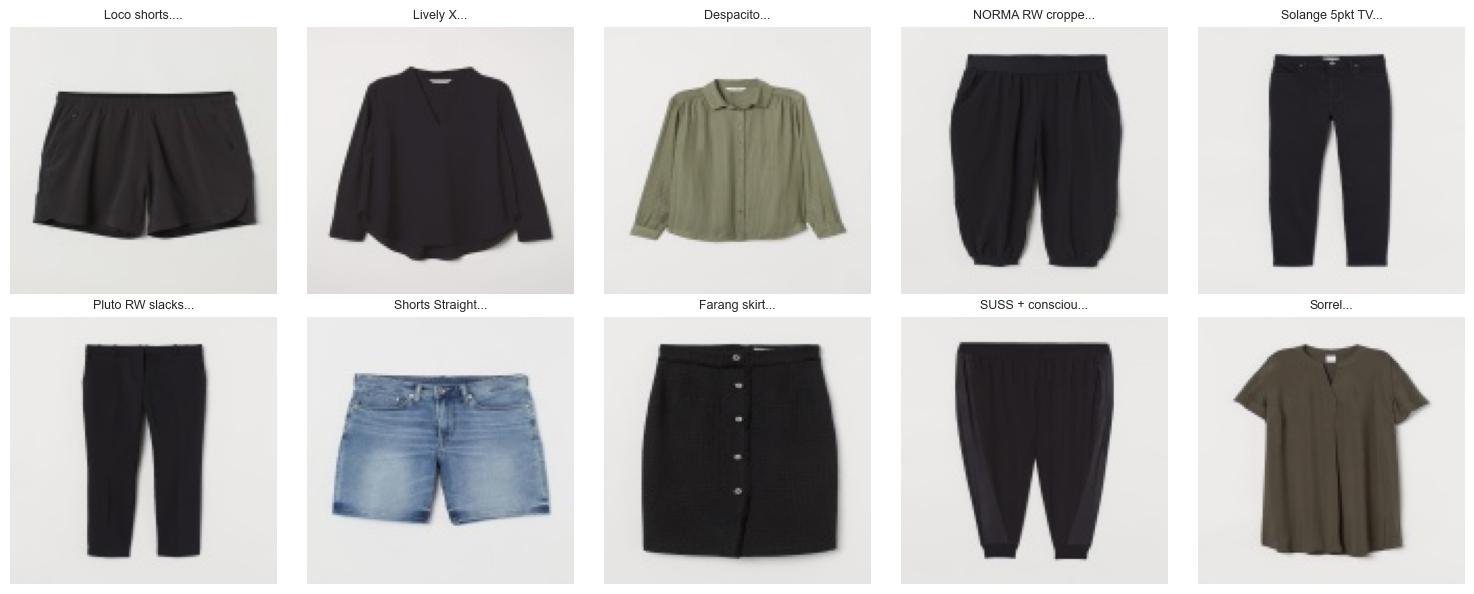


  CONTENT-BASED RECOMMENDATIONS
🏆 Heavy customer (42 purchases) → exponential decay weighting

🛍️ Recommendations for customer_id_enc = 46576


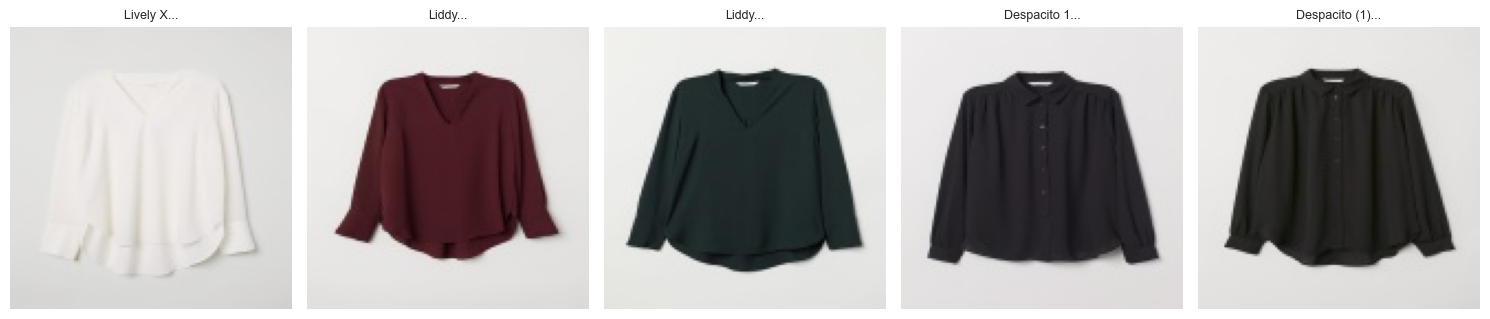


        ALS RECOMMENDATIONS

📊 ALS Recommendations for customer_id_enc = 46576


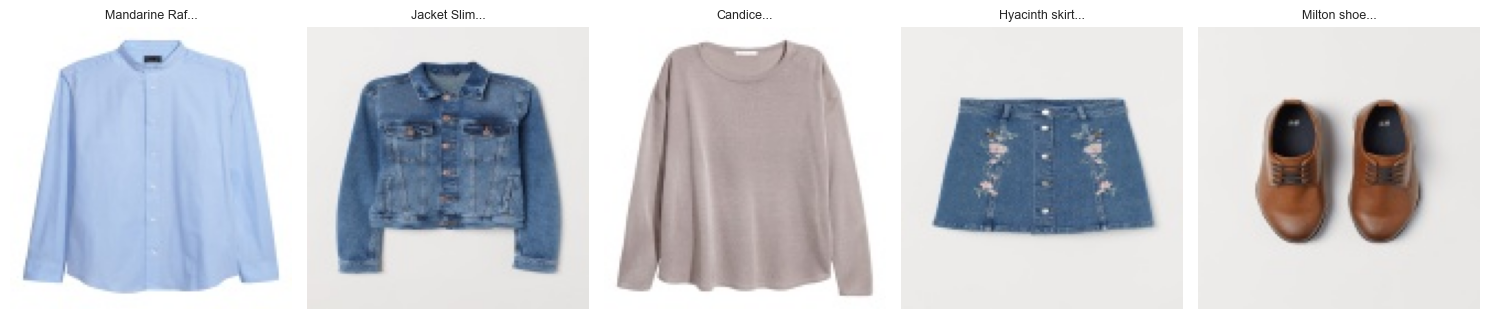

In [96]:
compare_cb_vs_als(customer_id_enc=46576, transactions=transactions, top_n=5)

In [97]:
transactions[transactions['customer_id_enc'] == 173170]

,t_dat,customer_id,article_id,price,sales_channel_id,customer_id_enc
991105,2018-10-11,207b29d1e7b50f02cf0c83db3c9c0a106403e0b60e8905...,572187001,0.025407,1,173170


In [98]:
# Create sparse user-item interaction matrix
rows = transactions['customer_id_enc'].astype('category').cat.codes
cols = transactions['article_id'].astype('category').cat.codes
data = np.ones(len(transactions), dtype=np.int8)

In [99]:
user_item_sparse = csr_matrix(
    (data, (rows, cols)),
    shape=(rows.max() + 1, cols.max() + 1)
)

In [100]:
print(user_item_sparse.shape)

(1362281, 104547)


In [102]:
# --- KNN Model for Similar Users (Top-K cosine similarity) ---
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn_model.fit(user_item_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [103]:
def get_similar_users(customer_id_enc, top_n=5):
    if customer_id_enc not in user_to_idx:
        return []

    user_idx = user_to_idx[customer_id_enc]
    distances, indices = knn_model.kneighbors(user_item_sparse[user_idx], n_neighbors=top_n + 1)
    similar_users = [idx_to_user[i] for i in indices.flatten()[1:]]  # Skip itself
    return similar_users

In [104]:
def get_items_from_similar_users(customer_id_enc, top_n=10, neighbor_k=50):
    # Step 1: Get similar users
    similar_users = get_similar_users(customer_id_enc, top_n=neighbor_k)
    if not similar_users:
        return []

    # Step 2: Items current user already bought
    user_items = set(transactions.loc[transactions['customer_id_enc'] == customer_id_enc, 'article_id'])

    # Step 3: Items bought by similar users + ranking by frequency
    sim_items = (
        transactions[transactions['customer_id_enc'].isin(similar_users)]
        .groupby('article_id').size()
        .sort_values(ascending=False)
    )

    # Step 4: Remove items already bought
    filtered_items = sim_items[~sim_items.index.isin(user_items)]

    # ✅ Fallback: If still empty, allow some overlap or use popular items
    if filtered_items.empty:
        print("⚠️ Similar users have no new items. Using fallback popular items.")
        popular_items = (
            transactions.groupby('article_id').size().sort_values(ascending=False)
        )
        filtered_items = popular_items[~popular_items.index.isin(user_items)]

    # Step 5: Return top-N
    return list(filtered_items.head(top_n).index)

In [105]:
# --- Content-Based: get similar items ---
def get_similar_items(article_id, top_n=10):
    if article_id not in id_to_index:
        return pd.DataFrame()
    idx = id_to_index[article_id]
    cosine_sim = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()
    sim_indices = cosine_sim.argsort()[-top_n-1:][::-1]
    sim_indices = sim_indices[sim_indices != idx]
    results = items_df.iloc[sim_indices][['article_id', 'prod_name']].copy()
    results['similarity'] = cosine_sim[sim_indices]
    return results.head(top_n)

In [106]:
# --- Show images utility ---
def show_images(recs, base_dir):
    if recs is None or len(recs) == 0:
        print("No recommendations available.")
        return
    fig, axes = plt.subplots(1, len(recs), figsize=(15, 4))
    if len(recs) == 1:
        axes = [axes]
    for ax, (_, row) in zip(axes, recs.iterrows() if isinstance(recs, pd.DataFrame) else enumerate(recs)):
        article_id = row['article_id'] if isinstance(recs, pd.DataFrame) else row
        prod_name = row['prod_name'] if isinstance(recs, pd.DataFrame) else ""
        img_path = get_image_path(article_id, base_dir)
        if os.path.exists(img_path):
            ax.imshow(mpimg.imread(img_path))
        ax.set_title(str(prod_name)[:15], fontsize=9)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [107]:
# --- Hybrid Recommender with Separated Output ---
def hybrid_recommendation_with_images(customer_id_enc, top_n=5, base_dir="images_128_128"):
    # Last purchased item
    last_item_row = transactions[transactions['customer_id_enc'] == customer_id_enc].sort_values('t_dat', ascending=False).head(1)
    if last_item_row.empty:
        print("No purchase history for this user.")
        return
    last_item = last_item_row['article_id'].values[0]

    # --- Content-based section ---
    print("\n==============================")
    print(" Content-Based Recommendations")
    print("==============================")
    content_recs = get_similar_items(last_item, top_n=top_n)
    show_images(content_recs, base_dir)

    # --- Similar users section ---
    print("\n==============================")
    print(" Similar Users Also Bought")
    print("==============================")
    sim_items = get_items_from_similar_users(customer_id_enc, top_n=top_n)
    sim_recs = items_df[items_df['article_id'].isin(sim_items)][['article_id', 'prod_name']]
    show_images(sim_recs, base_dir)


 Content-Based Recommendations


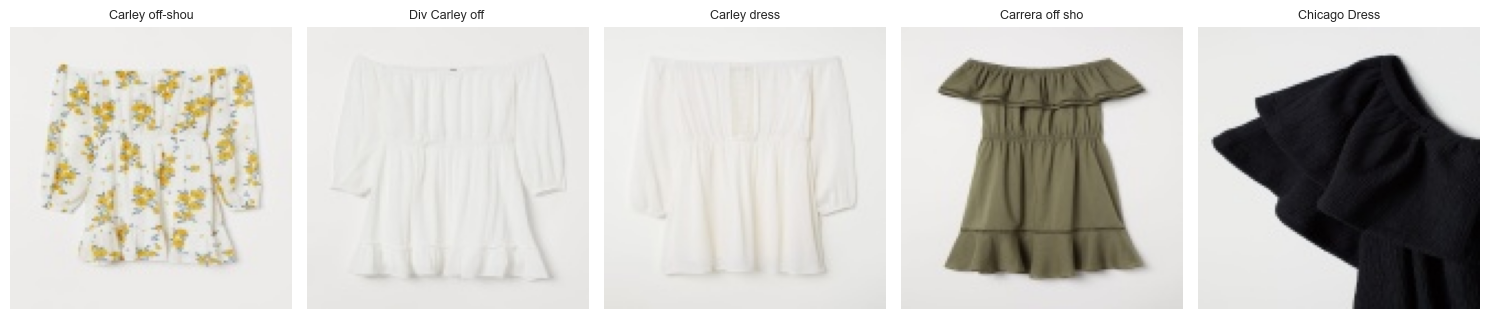


 Similar Users Also Bought


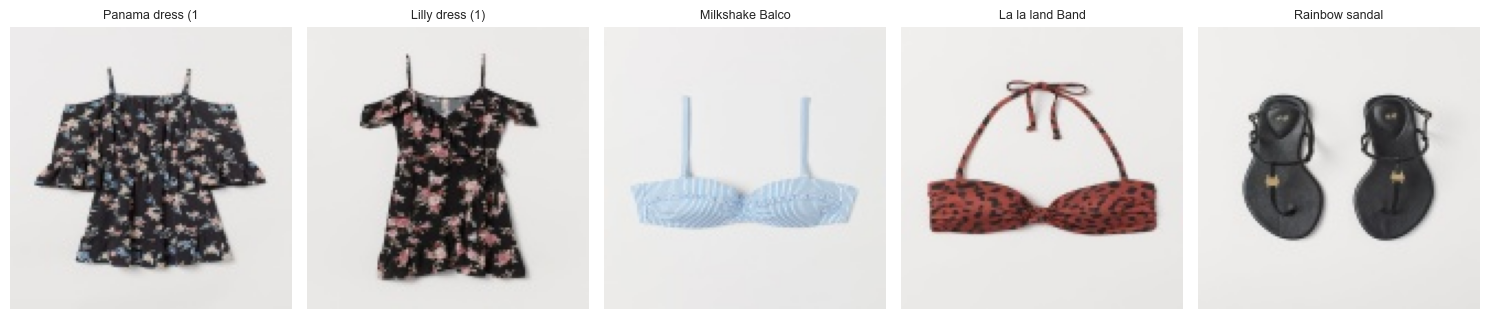

In [108]:
hybrid_recommendation_with_images(customer_id_enc=986, top_n=5)

In [109]:
get_similar_users(56732, top_n=5)

[np.int64(100792),
 np.int64(378969),
 np.int64(353682),
 np.int64(173170),
 np.int64(1296447)]